# Подготовка датасета

In [26]:
import numpy as np
from PIL import Image
import os

In [15]:
train_path = r'C:\Users\Danila\Desktop\2025-02-20-Omnipose train on Cellpose\Cellpose dataset for Omnipose\train'

files = os.listdir(train_path)
files = list(filter(lambda x: '.npy' in x, files))
for file in files:
    file_path = os.path.join(train_path, file)
    npy = np.load(file_path, allow_pickle=True)
    mask = npy.item()['masks']
    img = Image.fromarray(mask)
    img.save(os.path.join(train_path, file[:-3] + 'tif'))
    os.remove(file_path)

In [14]:
test_path = r'C:\Users\Danila\Desktop\2025-02-20-Omnipose train on Cellpose\Cellpose dataset for Omnipose\test'

files = os.listdir(test_path)
files = list(filter(lambda x: '.npy' in x, files))
for file in files:
    file_path = os.path.join(test_path, file)
    npy = np.load(file_path, allow_pickle=True)
    mask = npy.item()['masks']
    img = Image.fromarray(mask)
    img.save(os.path.join(test_path, file[:-3] + 'tif'))
    os.remove(file_path)

# Тестирование

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose_omni import metrics, utils, io, models
import os, shutil
from tqdm import tqdm
from scipy.ndimage import convolve
import omnipose

In [28]:
# set up plotting defaults
# from omnipose.plot import imshow
# omnipose.plot.setup()

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
from omnipose.gpu import use_gpu
use_GPU = use_gpu()
use_GPU

(device(type='cuda', index=0), True)

In [29]:
def boundary_scores(masks_true, masks_pred, scales):
    """
    Calculate boundary precision, recall, and F-score.

    Args:
        masks_true (list): List of true masks.
        masks_pred (list): List of predicted masks.
        scales (list): List of scales.

    Returns:
        tuple: A tuple containing precision, recall, and F-score arrays.
    """
    diams = [utils.diameters(lbl)[0] for lbl in masks_true]
    precision = np.zeros((len(scales), len(masks_true)))
    recall = np.zeros((len(scales), len(masks_true)))
    fscore = np.zeros((len(scales), len(masks_true)))
    for j, scale in enumerate(scales):
        for n in tqdm(range(len(masks_true))):
            diam = max(1, scale * diams[n])
            rs, ys, xs = utils.circleMask([int(np.ceil(diam)), int(np.ceil(diam))])
            filt = (rs <= diam).astype(np.float32)
            otrue = utils.masks_to_outlines(masks_true[n])
            otrue = convolve(otrue, filt)
            opred = utils.masks_to_outlines(masks_pred[n])
            opred = convolve(opred, filt)
            tp = np.logical_and(otrue == 1, opred == 1).sum()
            fp = np.logical_and(otrue == 0, opred == 1).sum()
            fn = np.logical_and(otrue == 1, opred == 0).sum()
            precision[j, n] = tp / (tp + fp)
            recall[j, n] = tp / (tp + fn)
        fscore[j] = 2 * precision[j] * recall[j] / (precision[j] + recall[j])
    return precision, recall, fscore


def test_model(train_labels, test_labels, train_eval, test_eval):
    print()
    print("Omnipose test")
    print()
    
    aji_train = metrics.aggregated_jaccard_index(train_labels, train_eval).mean()
    print(f"Aggregated jaccard index (train): {aji_train:.3f}")
    aji_test = metrics.aggregated_jaccard_index(test_labels, test_eval).mean()
    print(f"Aggregated jaccard index (test): {aji_test:.3f}")
    print()

    ap_train = metrics.average_precision(train_labels, train_eval)
    print("Average precision (train)")
    print(f"threshold 0.5: {ap_train[0][:,0].mean():.3f}")
    print(f"threshold 0.75): {ap_train[0][:,1].mean():.3f}")
    print(f"threshold 0.9): {ap_train[0][:,2].mean():.3f}")

    ap_test = metrics.average_precision(test_labels, test_eval)
    print("Average precision (test)")
    print(f"threshold 0.5: {ap_test[0][:,0].mean():.3f}")
    print(f"threshold 0.75): {ap_test[0][:,1].mean():.3f}")
    print(f"threshold 0.9): {ap_test[0][:,2].mean():.3f}")
    print()

    bs_train = boundary_scores(train_labels, train_eval, scales=[0.1])
    print("Boundary scores for (train, scale=0.1)")
    print("precision", bs_train[0].mean())
    print("recall", bs_train[1].mean())
    print("fscore", bs_train[2].mean())

    bs_test = boundary_scores(test_labels, test_eval, scales=[0.1])
    print("Boundary scores for (test, scale=0.1)")
    print("precision", bs_test[0].mean())
    print("recall", bs_test[1].mean())
    print("fscore", bs_test[2].mean())

In [30]:
train_dir = r'C:\Users\Danila\Desktop\2025-02-20-Omnipose train on Cellpose\Cellpose dataset for Omnipose\train'
test_dir = r'C:\Users\Danila\Desktop\2025-02-20-Omnipose train on Cellpose\Cellpose dataset for Omnipose\test'

output = io.load_train_test_data(train_dir, test_dir, mask_filter="_seg", look_one_level_down=False)
# images, labels, image_names, test_images, test_labels, image_names_test = output
images, labels, links, image_names, test_images, test_labels, test_links, image_names_test = output

2025-02-21 16:53:35,803	[INFO]                                               	 line 303	not all flows are present, will run flow generation for all images
2025-02-21 16:53:36,145	[INFO]                                               	 line 303	not all flows are present, will run flow generation for all images


In [31]:
# model masks

def read_masks(path, mask_filter='_cp_masks'):
    masks = []
    files = os.listdir(path)
    files = list(filter(lambda x: mask_filter in x, files))
    for file in files:
        file_path = os.path.join(path, file)
        image = Image.open(file_path)
        masks.append(np.array(image, dtype=np.uint16))
    return masks


train_eval = read_masks(r'C:\Users\Danila\Desktop\2025-02-20-Omnipose train on Cellpose\For omnipose testing\train\masks')
test_eval = read_masks(r'C:\Users\Danila\Desktop\2025-02-20-Omnipose train on Cellpose\For omnipose testing\test\masks')

In [32]:
# model_path = r'C:\Users\Danila\Desktop\2025-02-20-Omnipose train on Cellpose\Cellpose dataset for Omnipose\train\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_3_nchan_2_dim_2_train_2025_02_20_18_09_12.523263'

test_model(
    # model_path=model_path,
    # train_images = images,
    train_labels = labels,
    # test_images = test_images,
    test_labels = test_labels,
    train_eval = train_eval,
    test_eval = test_eval,
)


Omnipose test

Aggregated jaccard index (train): 0.810
Aggregated jaccard index (test): 0.701

Average precision (train)
threshold 0.5: 0.850
threshold 0.75): 0.817
threshold 0.9): 0.491
Average precision (test)
threshold 0.5: 0.743
threshold 0.75): 0.709
threshold 0.9): 0.395



100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [03:08<00:00,  2.86s/it]


Boundary scores for (train, scale=0.1)
precision 0.8287120968626853
recall 0.8452631242849302
fscore 0.8354655944969689


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:25<00:00,  2.94s/it]

Boundary scores for (test, scale=0.1)
precision 0.7462770991744784
recall 0.7539160863049159
fscore 0.7423005219979117


In [32]:
# Не работает

model = models.CellposeModel(gpu=True, pretrained_model=model_path, diam_mean=102, omni=True, nchan=2, nclasses=3, dim=2)
train_eval, flows, styles = model.eval([images[10]], channels=[0,0], diameter=102, net_avg=False)

2025-02-21 14:47:09,957	[INFO]     cellpose_omni\core.py         assi...evice()	 line  67	Using GPU.
2025-02-21 14:47:10,047	[INFO]                                   __init__....()	 line 173	u-net config: ([2, 32, 64, 128, 256], 4, 2)
2025-02-21 14:47:10,177	[WARNING]  cellpose_omni\models.py       eval........()	 line 724	input images do not match the expected number of dimensions (2) 
and channels (2) of model.
2025-02-21 14:47:10,177	[INFO]                                               	 line 1124	using dataparallel


AttributeError: 'list' object has no attribute 'ndim'

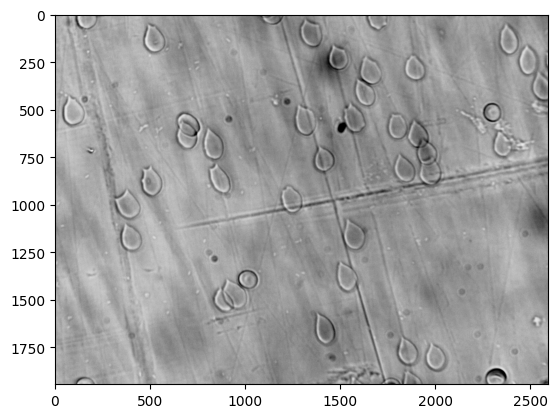

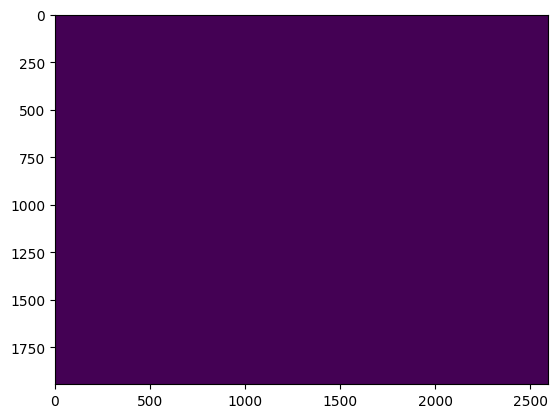

In [33]:
plt.imshow(images[10])
plt.show()
plt.imshow(train_eval)
plt.show()